## Метрические методы классификации и регрессии. K-ближайших соседей. Метод окна Парзена. Формула Надарая-Ватсона. 
### Ноутбук составлен по мотивам лекций профессора Воронцова по ML для МФТИ и ШАД, а также https://ml-handbook.ru/chapters/metric_based/intro

### 1. KNN

Реализуем метод К ближайших соседей. Для этого генерируем тестовый и тренировочный датасеты из трех классов с двумя признаками

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, Y = make_classification(n_samples=150, n_features=2, 
                           n_informative=2, n_classes=3, 
                           n_redundant=0,
                           n_clusters_per_class=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=50)

Для красоты отрисуем в 3D

/tmp/ipykernel_15084/2623199464.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


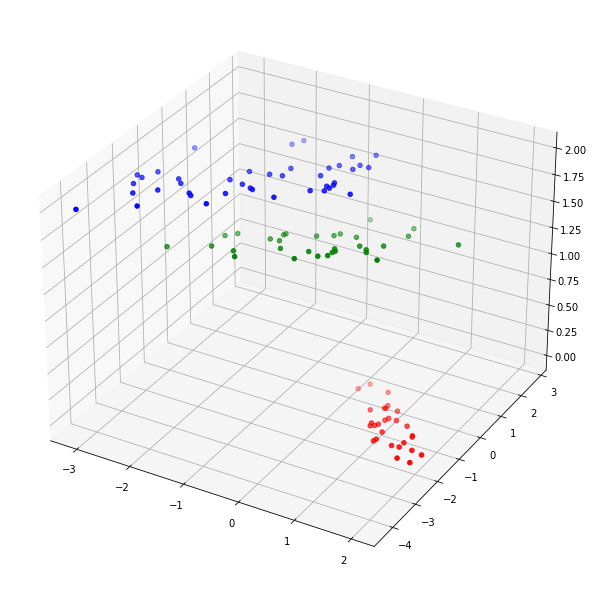

In [2]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


fig = pylab.figure(figsize=(8, 8))
axes = Axes3D(fig)
axes.scatter3D(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 1], Y_train[np.where(Y_train==0)], c = 'r')
axes.scatter3D(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 1], Y_train[np.where(Y_train==1)], c = 'g')
axes.scatter3D(X_train[np.where(Y_train==2), 0], X_train[np.where(Y_train==2), 1], Y_train[np.where(Y_train==2)], c = 'b')
pylab.show()

Для наглядности отрисуем в 2D

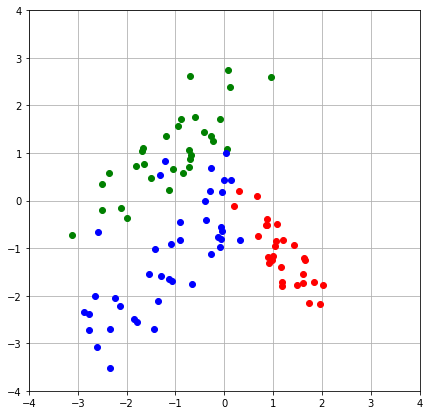

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7, 7))
plt.plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 1], 'ro')
plt.plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 1], 'go')
plt.plot(X_train[np.where(Y_train==2), 0], X_train[np.where(Y_train==2), 1], 'bo')
plt.grid()
plt.axis([-4, 4, -4, 4])
plt.show()

KNN подразумевает определение расстояния до соседей, чтобы их затем упорядочить по критерию этого расстояния. Реализуем евклидову метрику 
### $$\rho (x, y) = \sqrt{\Sigma _i (x _i - y_i)^2}$$
, где i - количество признаков каждого объекта

In [4]:
def eucl_dist(x_test, x_train):
    #переводим все в numpy, если вдруг на входе получили простые списки
    
    x_test = np.array(x_test, dtype = np.single)
    x_train = np.array(x_train, dtype = np.single)
    
    """
    Дальше внимательно: если тренировочный датасет 100 элементов, а тестовый 50, и в каждом элементе 2 признака, нам придется шаманить с массивами,
    так как идти циклом поэлементно, чтобы получить расстояние между каждым из 50 тестовых и 100 тренировочных - совсем моветон, при этом никакой бродкаст 
    на массивах (50, 2) и (100, 2) не отработает, поэтому одной операцией такое вычитание с последующим возведением в степень и сложением не провести. 
    
    Что придется сделать:
    Скопировать каждый элемент тестового массива 100 раз, чтобы между ним и каждым элементом тренировочного массива можно было считать расстояние одной операцией.
    Сначала копируем массив 100 раз и получаем 100 массивов (50, 2), затем делаем stack по направлению axis = 1, что даст (50, 100, 2). Далее numpy даст вычесть
    из получившегося (50, 100, 2) массив (100, 2) - он сделает бродкаст вычитаемого по axis=0, чтобы получить массивы одинакового размера. 
    """
    
    arrays = [x_test for i in range(x_train.shape[0])]
    x_test = np.stack(arrays, axis = 1)    #(получили (50, 100, 2))
    return np.power(np.sum(np.power(x_test - x_train, 2), axis = 2), 1/2)

Реализуем класс KNN. 

Зачем класс, ведь можно было просто метод? Хочется рисовать диаграммы типа decision regions, см. ниже. Функция plot_decision_regions на вход требует не функцию, а объект классификатора с реализованным методом predict, которому на вход подается массив X_test. 

In [5]:
class my_KNN:
    
    def __init__(self, X_train, Y_train, k = 3):
        self.X_train = np.array(X_train, dtype = np.single)
        self.Y_train = np.array(Y_train, dtype = np.single)
        self.k = k
    
    def predict(self, X_test):
        
        """
        С массивом Y_train придется сделать то же самое, что и с X_test. Так как нам придется для определения класса каждого элемента X_test брать классы 
        упорядоченных элементов тренировочного набора, нужно скопировать классы тренировочного набора X_test раз, чтобы классификация выполнялась 
        в векторной форме. 
        Ниже можно раскомментировать принты, чтобы посмотреть операции, если непонятно.
        """
        
        distances = eucl_dist(X_test, X_train)
        arrays = [self.Y_train for i in range(X_test.shape[0])]
        Y_train = np.stack(arrays, axis = 0)    # теперь Y_train стал размером (50, 100)
        
        # print("Y_train.shape = ", Y_train.shape)
        # print("distances.shape = ", distances.shape)
        # print("np.argsort(distances, axis = 1).shape = ", np.argsort(distances, axis = 1).shape)
        # print(np.argsort(distances, axis = 1)[0])
        # print(np.take_along_axis(distances, np.argsort(distances, axis = 1), axis = 1))
        # print(np.take_along_axis(Y_train, np.argsort(distances, axis = 1), axis = 1)[:, :self.k])
        # print(np.median(np.take_along_axis(Y_train, np.argsort(distances, axis = 1), axis = 1)[:, :self.k], axis = 1))
        
        """
        Пояснения: 
        
        np.argsort возвращает индексы, которые отсортируют массив. Если работать с массивом distances размерностью (50, 100) с аргументом axis=1, то
        сортировка произойдет как раз по направлению 100 - по дистанциям между элементом тестовой выборки и каждым из 100 элементов тренировочной. 
        
        np.take_along_axis - позволяет отсортировать массив Y_train размерностью (50, 100), воспользовавшись индексами на выходе с np.argsort, размерность которых
        тоже (50, 100). Зачем тогда нужен take_along_axis? Нужен, так как просто подстановка Y_train[np.argsort(distances, axis = 1)] не работает,
        numpy не понимает, по какому измерению сортировать.
        
        np.median - понятно. Берем наиболее часто встречающийся элемент в качестве класса. 
        [:, :self.k] - берем только k ближайших соседей.
        """
        
        return np.median(np.take_along_axis(Y_train, np.argsort(distances, axis = 1), axis = 1)[:, :self.k], axis = 1)

In [6]:
cls3 = my_KNN(X_train, Y_train, k = 3)
cls5 = my_KNN(X_train, Y_train, k = 5)
cls11 = my_KNN(X_train, Y_train, k = 11)
cls15 = my_KNN(X_train, Y_train, k = 15)

In [7]:
from mlxtend.plotting import plot_decision_regions
from matplotlib import gridspec

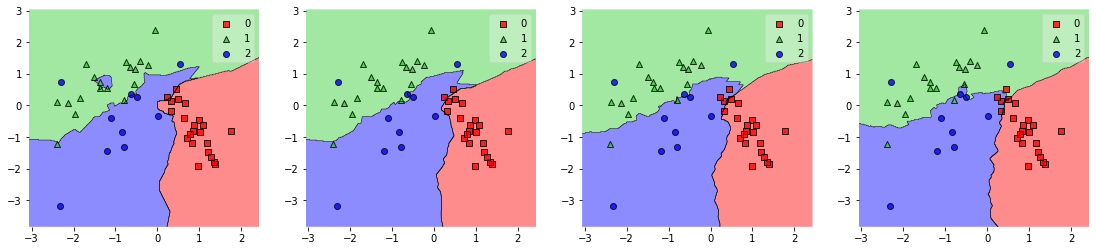

In [8]:
fig, gs = plt.figure(figsize=(19, 4)), gridspec.GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

plot_decision_regions(X_test, Y_test, cls3, ax=ax[0], colors = 'red,limegreen,blue,gray,cyan', zoom_factor = 1.5)
plot_decision_regions(X_test, Y_test, cls5, ax=ax[1], colors = 'red,limegreen,blue,gray,cyan', zoom_factor = 1.5)
plot_decision_regions(X_test, Y_test, cls11, ax=ax[2], colors = 'red,limegreen,blue,gray,cyan', zoom_factor = 1.5)
plot_decision_regions(X_test, Y_test, cls15, ax=ax[3], colors = 'red,limegreen,blue,gray,cyan', zoom_factor = 1.5)

plt.show()

Реализуем дополнительные способы измерения расстояния и перепишем класс my_KNN, чтобы ему на вход можно было подавать функцию вычисления расстояния

In [9]:
def manhattan(x_test, x_train):
    x_test = np.array(x_test, dtype = np.single)
    x_train = np.array(x_train, dtype = np.single)
    arrays = [x_test for i in range(x_train.shape[0])]
    x_test = np.stack(arrays, axis = 1)
    return np.sum(np.abs(x_test - x_train), axis = 2)

In [10]:
def cosine(x_test, x_train):
    x_test = np.array(x_test, dtype = np.single)
    x_train = np.array(x_train, dtype = np.single)
    arrays = [x_test for i in range(x_train.shape[0])]
    x_test = np.stack(arrays, axis = 1)
    return 1 - np.sum(x_test*x_train, axis = 2)/(np.power(np.sum(np.power(x_test, 2), axis = 2), 1/2) * np.power(np.sum(np.power(x_train, 2), axis = 1), 1/2))

Переписываем класс KNN

In [11]:
class my_KNN2:
    
    def __init__(self, X_train, Y_train, k = 3, dist = eucl_dist):
        self.X_train = np.array(X_train, dtype = np.single)
        self.Y_train = np.array(Y_train, dtype = np.single)
        self.k = k
        self.dist = dist
    
    def predict(self, X_test):
        distances = self.dist(X_test, X_train)
        arrays = [self.Y_train for i in range(X_test.shape[0])]
        Y_train = np.stack(arrays, axis = 0)
        return np.median(np.take_along_axis(Y_train, np.argsort(distances, axis = 1), axis = 1)[:, :self.k], axis = 1)

In [12]:
cls2_3 = my_KNN2(X_train, Y_train, k = 3, dist = manhattan)
cls2_5 = my_KNN2(X_train, Y_train, k = 5, dist = manhattan)
cls2_11 = my_KNN2(X_train, Y_train, k = 11, dist = manhattan)
cls2_15 = my_KNN2(X_train, Y_train, k = 15, dist = manhattan)

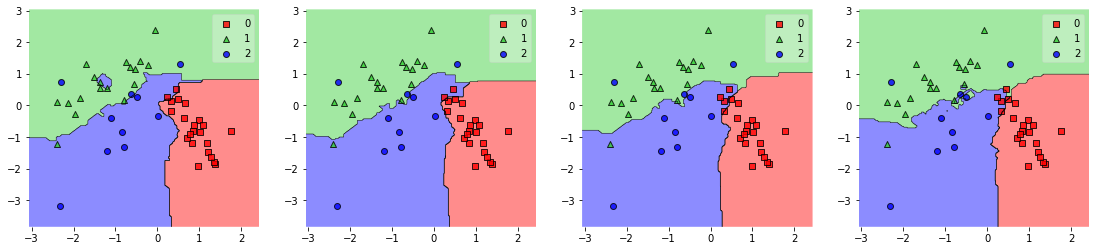

In [13]:
fig, gs = plt.figure(figsize=(19, 4)), gridspec.GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

plot_decision_regions(X_test, Y_test, cls2_3, ax=ax[0], colors = 'red,limegreen,blue,gray,cyan', zoom_factor = 1.5)
plot_decision_regions(X_test, Y_test, cls2_5, ax=ax[1], colors = 'red,limegreen,blue,gray,cyan', zoom_factor = 1.5)
plot_decision_regions(X_test, Y_test, cls2_11, ax=ax[2], colors = 'red,limegreen,blue,gray,cyan', zoom_factor = 1.5)
plot_decision_regions(X_test, Y_test, cls2_15, ax=ax[3], colors = 'red,limegreen,blue,gray,cyan', zoom_factor = 1.5)

plt.show()

In [14]:
cls3_3 = my_KNN2(X_train, Y_train, k = 3, dist = cosine)
cls3_5 = my_KNN2(X_train, Y_train, k = 5, dist = cosine)
cls3_11 = my_KNN2(X_train, Y_train, k = 11, dist = cosine)
cls3_15 = my_KNN2(X_train, Y_train, k = 15, dist = cosine)

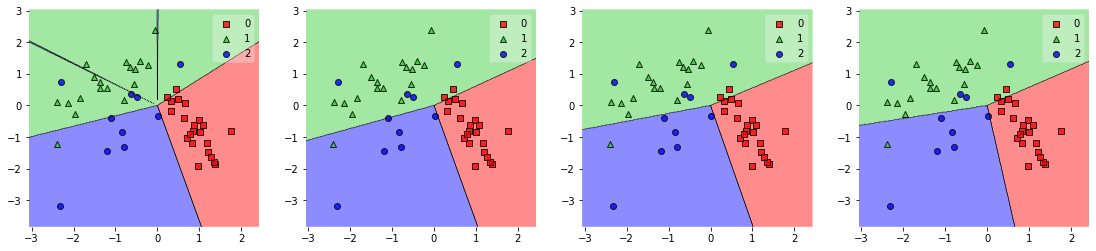

In [15]:
fig, gs = plt.figure(figsize=(19, 4)), gridspec.GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

plot_decision_regions(X_test, Y_test, cls3_3, ax=ax[0], colors = 'red,limegreen,blue,gray,cyan', zoom_factor = 1.5)
plot_decision_regions(X_test, Y_test, cls3_5, ax=ax[1], colors = 'red,limegreen,blue,gray,cyan', zoom_factor = 1.5)
plot_decision_regions(X_test, Y_test, cls3_11, ax=ax[2], colors = 'red,limegreen,blue,gray,cyan', zoom_factor = 1.5)
plot_decision_regions(X_test, Y_test, cls3_15, ax=ax[3], colors = 'red,limegreen,blue,gray,cyan', zoom_factor = 1.5)

plt.show()